# Behavioral Heuristic Labeling Engine

In this section, we construct the deterministic scoring function, `score_instruction_following`, that evaluates whether a language model's output **follows the explicit instruction or constraints** contained within the prompt. This function transforms the qualitative concept of "obedience" into a reproducible, quantitative metric.

---

##  Function Signature and Output

The function will take the three key dialogue segments and a set of constraint tags ($T$) to compute a binary outcome ($y$) and a list of reasons. Note that per our agreed-upon signature, the function will infer the constraint tags $T$ from the system ($s$) and user ($u$) text itself.

Given an example consisting of:
* **System text** ($s$): The system-level instruction/prompt.
* **User text** ($u$): The latest user query.
* **Model output** ($a$): The assistant's generated response.
* **Constraint tags** ($T$): *Inferred* constraint types (e.g., $\text{length\_limit}$).

Our goal is to compute the resulting dictionary:

$$
\text{score\_instruction\_following}(s, u, a)
\;\longrightarrow\;
\{\,y, \text{reasons}\,\}
$$

##  Compliance Metric ($y$)

The core output $y$ is a binary compliance score defined as:

$$
y =
\begin{cases}
1 & \text{if all applicable constraints are satisfied},\\[6pt]
0 & \text{if at least one constraint is violated},\\[6pt]
\text{undefined} & \text{if no explicit constraint is found or evaluable}.
\end{cases}
$$

---

We begin by unit-testing the rule engine against **synthetic examples** covering our locked constraint taxonomy (e.g., `length_limit`, `format_json`). The full labeling run will commence in Week 2/3 when the model outputs ($a$) and the **`selected.jsonl`** dataset (generated by Researcher 1) become available.


In [1]:
from google.colab import files
import json
import re
from typing import Dict, Any, List, Optional

import pandas as pd

print("Upload selected_all_shuffled.jsonl (from Researcher 1)")
uploaded = files.upload()

# The uploaded dict keys are the filenames
print("Uploaded files:", list(uploaded.keys()))


Upload selected_all_shuffled.jsonl (from Researcher 1)


Saving merged_dataset_with_outputs (1).jsonl to merged_dataset_with_outputs (1).jsonl
Uploaded files: ['merged_dataset_with_outputs (1).jsonl']


## Loading the Selected Prompt Dataset

The file `selected_all_shuffled.jsonl` contains all prompt components we need:
$$[
(s_i, u_i, T_i, \text{id}_i)
$$]

Each line is one JSON object containing fields such as:
- `system_text`
- `user_text`
- `constraint_tags`
- `dataset`
- `id`

We load this file into a dictionary so we can later join it with model outputs
(or dummy outputs during Week 1).


In [2]:
# Adjust this if the filename differs after upload
SELECTED_PATH = "/content/merged_dataset_with_outputs (1).jsonl"

# 1. Load selected examples into a dict keyed by id
selected_by_id: Dict[str, Dict[str, Any]] = {}
with open(SELECTED_PATH, "r") as f:
    for line in f:
        ex = json.loads(line)
        selected_by_id[ex["id"]] = ex

print("Number of selected examples:", len(selected_by_id))

# Peek at one example
example_id, example = next(iter(selected_by_id.items()))
example_id, {k: example.get(k) for k in ["dataset", "system_text", "user_text", "constraint_tags"]}


Number of selected examples: 300


('flan:18218',
 {'dataset': 'flan',
  'system_text': 'In this task, you\'re given a paragraph from the research paper and your task is to generate a suitable title for the research paper based on the given paper. Under 100 words is a good title length.\n\n[EX Q]: Influenza A virus (IAV) is a major cause of respiratory illness. Given the disease severity, associated economic costs, and recent appearance of novel IAV strains, there is a renewed interest in developing novel and efficacious "universal" IAV vaccination strategies. Recent studies have highlighted that immunizations capable of generating local (i.e., nasal mucosa and lung) tissue-resident memory T and B cells in addition to systemic immunity offer the greatest protection against future IAV encounters. Current IAV vaccines are designed to largely stimulate IAV-specific antibodies, but do not generate the lung-resident memory T and B cells induced during IAV infections. Herein, we report on an intranasally administered biocompa

## 📝 Implementing the Heuristic Scoring Function

We define a small taxonomy of constraints based on system instructions:

* **`length_limit`**
    A maximum number of words $N$.
    The output must satisfy:
    $$
    |a|_{\text{words}} \leq N
    $$

* **`keyword_X`**
    Required keywords $\{k_1, \ldots, k_m\}$.
    The output must contain all keywords (case-insensitive).

* **`format_json`**
    The output must be valid JSON:
    $$
    \text{valid\_json}(a) = 1
    $$

* **`no_explanations`**
    The output must *not* contain explanation markers such as "because," and may need to start with one of the allowed multiple-choice options.

* **`tone_concise`**
    Approximated via a word-count threshold.

The scoring function performs the following steps:

1.  Parse constraint parameters from the prompt text.
2.  Run each constraint check.
3.  Aggregate into one final label $y_i$.
4.  Return both the label and diagnostic strings ("reasons").

---

Below we implement the full heuristic engine.

In [3]:
# ---------- Constraint parsing helpers ----------

LENGTH_PATTERNS = [
    r"no more than\s+(\d+)\s+words",
    r"less than\s+(\d+)\s+words",
    r"under\s+(\d+)\s+words",
    r"in\s+(\d+)\s+words",
]


def parse_length_limit(text: str) -> Optional[int]:
    """Parse a maximum word count N from the prompt text, if present."""
    t = text.lower()
    for pattern in LENGTH_PATTERNS:
        m = re.search(pattern, t)
        if m:
            return int(m.group(1))
    return None


def parse_keywords(text: str) -> List[str]:
    """
    Extract required keywords from the prompt.

    Supports patterns like:
    - use the word "X"
    - use the phrase 'X'
    - List: item1, item2
    """
    keywords: List[str] = []

    word_patterns = [
        r"use the word ['\"]([^'\"]+)['\"]",
        r"use the phrase ['\"]([^'\"]+)['\"]",
        r"use the words ['\"]([^'\"]+)['\"]",
    ]
    for p in word_patterns:
        for m in re.finditer(p, text, flags=re.IGNORECASE):
            keywords.append(m.group(1))

    # Handle simple "List: Mount, Everest" style patterns
    list_match = re.search(r"List:\s*([^.\n]+)", text, flags=re.IGNORECASE)
    if list_match:
        parts = [w.strip() for w in re.split(r"[,\s]+", list_match.group(1)) if w.strip()]
        keywords.extend(parts)

    # De-duplicate (case-insensitive)
    seen = set()
    uniq = []
    for kw in keywords:
        if kw.lower() not in seen:
            seen.add(kw.lower())
            uniq.append(kw)
    return uniq


def parse_options_from_text(text: str) -> List[str]:
    """
    For 'no_explanations': extract answer options from
    patterns like 'Options: - yes - no - it is not possible to tell'.
    """
    options = []
    m = re.search(r"Options:\s*(.*)", text, flags=re.IGNORECASE | re.DOTALL)
    if not m:
        return options
    tail = m.group(1)
    # split on '- ' bullet style
    for part in tail.split("-"):
        opt = part.strip(" \n\t.:").lower()
        if opt:
            options.append(opt)
    return options


# ---------- Atomic checks ----------

def check_length_limit(answer: str, max_words: int) -> (bool, str):
    words = [w for w in answer.strip().split() if w]
    n = len(words)
    if n <= max_words:
        return True, f"length_ok({n}/{max_words})"
    else:
        return False, f"length_violation({n}/{max_words})"


def check_format_json(answer: str) -> (bool, str):
    try:
        json.loads(answer)
        return True, "json_ok"
    except Exception:
        return False, "json_invalid"


def check_keywords(answer: str, keywords: List[str]) -> (bool, str):
    if not keywords:
        return True, "keywords_na"
    lower = answer.lower()
    missing = [kw for kw in keywords if kw.lower() not in lower]
    if not missing:
        return True, "keywords_ok"
    else:
        return False, f"keywords_missing({','.join(missing)})"


EXPLANATION_MARKERS = [
    "because",
    "for example",
    "for instance",
    "this is because",
    "let me explain",
]


def check_no_explanations(answer: str, allowed_options: List[str]) -> (bool, str):
    ans = answer.strip().lower()

    # If we have explicit options, ensure answer starts with one of them
    if allowed_options:
        if not any(ans.startswith(opt) for opt in allowed_options):
            return False, "no_explanations_violation(option_mismatch)"

    # Disallow obvious explanation markers
    if any(m in ans for m in EXPLANATION_MARKERS):
        return False, "no_explanations_violation(explanation_marker)"

    # Optionally enforce a short length (crude)
    words = ans.split()
    if len(words) > 20:
        return False, f"no_explanations_violation({len(words)} words)"

    return True, f"no_explanations_ok({len(words)} words)"


def check_tone_concise(answer: str, max_words: int = 80) -> (bool, str):
    words = [w for w in answer.strip().split() if w]
    n = len(words)
    if n <= max_words:
        return True, f"tone_concise_ok({n}/{max_words})"
    else:
        return False, f"tone_concise_violation({n}/{max_words})"


# ---------- Main scoring function ----------

def score_instruction_following(
    system_text: str,
    user_text: str,
    assistant_generated: str,
    constraint_tags: List[str],
) -> Dict[str, Any]:
    """
    Heuristic scoring for instruction-following.

    Returns a dict with:
      - label: 0 | 1 | None
      - reasons: list of strings
      - per_constraint: dict of constraint -> bool/None
    """
    combined_text = (system_text or "") + "\n" + (user_text or "")

    reasons: List[str] = []
    per_constraint: Dict[str, Optional[bool]] = {
        "length_limit": None,
        "keyword_X": None,
        "format_json": None,
        "no_explanations": None,
        "tone_concise": None,
    }

    applicable_results: List[bool] = []

    # length_limit
    if "length_limit" in constraint_tags:
        max_words = parse_length_limit(combined_text)
        if max_words is not None:
            ok, reason = check_length_limit(assistant_generated, max_words)
            per_constraint["length_limit"] = ok
            reasons.append(reason)
            applicable_results.append(ok)
        else:
            reasons.append("length_limit_unparsed")

    # keyword_X
    if "keyword_X" in constraint_tags:
        kws = parse_keywords(combined_text)
        ok, reason = check_keywords(assistant_generated, kws)
        per_constraint["keyword_X"] = ok
        reasons.append(reason)
        applicable_results.append(ok)

    # format_json
    if "format_json" in constraint_tags:
        ok, reason = check_format_json(assistant_generated)
        per_constraint["format_json"] = ok
        reasons.append(reason)
        applicable_results.append(ok)

    # no_explanations
    if "no_explanations" in constraint_tags:
        options = parse_options_from_text(combined_text)
        ok, reason = check_no_explanations(assistant_generated, options)
        per_constraint["no_explanations"] = ok
        reasons.append(reason)
        applicable_results.append(ok)

    # tone_concise
    if "tone_concise" in constraint_tags:
        ok, reason = check_tone_concise(assistant_generated)
        per_constraint["tone_concise"] = ok
        reasons.append(reason)
        applicable_results.append(ok)

    # persona is intentionally not scored right now

    # aggregate label
    if applicable_results:
        label = 1 if all(applicable_results) else 0
    else:
        label = None

    return {
        "label": label,
        "reasons": reasons,
        "per_constraint": per_constraint,
    }


## Creating Synthetic Model Outputs for Week 1

Because real model outputs are generated in **Week 2** of the project
(after running LLaMA/Mistral inference), we use **synthetic outputs**
to test the heuristic pipeline end-to-end.

Let:
\[
\widetilde{a}_i
\]
denote a dummy answer we fabricate.  
These test outputs allow us to:

- verify all heuristics work,
- confirm CSV formatting,
- compute preliminary summary statistics,
- demonstrate a complete Week-1 deliverable,
- without requiring real model runs yet.

The synthetic answers intentionally include a mix of:
- short vs. long responses,
- valid vs. invalid JSON,
- keyword present vs. missing,
- explanation vs. no explanation.

This exercises all branches of the scoring logic.


In [4]:
import random

rows = []

# Take the first N examples for debugging (you can change N)
N = 100
example_items = list(selected_by_id.items())[:N]

def make_dummy_answer(base: Dict[str, Any], i: int) -> str:
    """
    Very simple fake answers:
      - sometimes short,
      - sometimes long,
      - sometimes valid JSON,
      - sometimes explanatory.
    This is just to exercise the heuristics.
    """
    tags = base.get("constraint_tags", [])

    # if it wants JSON, sometimes give valid JSON, sometimes not
    if "format_json" in tags:
        if i % 2 == 0:
            return '{"answer": "ok", "value": 1}'
        else:
            return "not valid json"

    # if it wants no_explanations, alternate between bare "yes"/"no" and explanation
    if "no_explanations" in tags:
        return "yes" if i % 2 == 0 else "yes, because the premise clearly entails the hypothesis."

    # if it wants a length limit, alternate short vs long
    if "length_limit" in tags:
        if i % 2 == 0:
            return "Short answer within limit."
        else:
            return "This is a deliberately long answer that is likely to exceed any short word-limit constraint."

    # if it wants keyword_X, sometimes include the word "caution", sometimes not
    if "keyword_X" in tags:
        return "Proceed with caution near wet floors." if i % 2 == 0 else "Be careful."

    # default: some generic answer
    return "This is a generic dummy answer."

for i, (ex_id, base) in enumerate(example_items):
    answer = make_dummy_answer(base, i)

    res = score_instruction_following(
        base.get("system_text", ""),
        base.get("user_text", ""),
        answer,
        base.get("constraint_tags", []),
    )
    per = res["per_constraint"]

    row = {
        "id": ex_id,
        "dataset": base.get("dataset", ""),
        "constraint_tags": ";".join(base.get("constraint_tags", [])),
        "assistant_generated": answer,
        "label": res["label"],
        "length_ok": per["length_limit"],
        "keyword_ok": per["keyword_X"],
        "json_ok": per["format_json"],
        "no_explanations_ok": per["no_explanations"],
        "tone_concise_ok": per["tone_concise"],
        "reasons": ";".join(res["reasons"]),
    }
    rows.append(row)

len(rows)


100

## Constructing the Behavior Labels Table

For each example $i$, we compute the binary compliance score $y_i$:

$$
y_i = \text{score\_instruction\_following}(s_i, u_i, \widetilde{a}_i, T_i).
$$

We record the following key data points into our final artifact:
* The **final label** $y_i$ (0 or 1).
* **Per-constraint pass/fail values** (e.g., `length_ok`, `json_ok`).
* The model's (synthetic) output $\widetilde{a}_i$.
* A human-readable **reasons list** for debugging.

All results are written to the file:

$$
\texttt{behavior\_labels.csv}
$$

This CSV file serves as the main and most critical **artifact** produced by the Behavior Analyst role in **Week 1**, providing the behavioral ground truth for all subsequent correlation analysis.

In [5]:
OUT_CSV = "behavior_labels.csv"

df_labels = pd.DataFrame(rows)
df_labels.head()


,id,dataset,constraint_tags,assistant_generated,label,length_ok,keyword_ok,json_ok,no_explanations_ok,tone_concise_ok,reasons
0,flan:18218,flan,length_limit,Short answer within limit.,1.0,True,None,None,None,None,length_ok(4/100)
1,flan:5057,flan,length_limit,This is a deliberately long answer that is lik...,1.0,True,None,None,None,None,length_ok(15/15)
2,alpaca:23572,alpaca,length_limit,Short answer within limit.,1.0,True,None,None,None,None,length_ok(4/100)
3,flan:1998,flan,length_limit,This is a deliberately long answer that is lik...,NaN,None,None,None,None,None,length_limit_unparsed
4,sharegpt_en:3902,sharegpt,length_limit,Short answer within limit.,1.0,True,None,None,None,None,length_ok(4/800)


In [6]:
df_labels.to_csv(OUT_CSV, index=False)
print("Wrote", OUT_CSV, "with", len(df_labels), "rows")


Wrote behavior_labels.csv with 100 rows


In [7]:
from google.colab import files
files.download(OUT_CSV)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##  Computing Summary Statistics

Before concluding the Week 1 deliverable, we compute empirical compliance rates using the binary labels and per-constraint flags recorded in `behavior_labels.csv`.

We first define $\mathcal{D}$ as the set of examples for which the heuristic successfully produced a valid, non-null label:

$$
\mathcal{D} = \{\, i \mid y_i \in \{0,1\} \,\}.
$$

---

### 1. Overall Instruction-Following Rate

This metric gives the mean probability of compliance across all testable examples:

$$
\hat{p}_{\text{overall}}
= \frac{1}{|\mathcal{D}|} \sum_{i \in \mathcal{D}} y_i
$$

---

### 2. Per-Dataset Compliance

For each dataset $d \in \{\text{Alpaca}, \text{FLAN}, \text{ShareGPT}\}$, we compute the dataset-specific compliance rate, where $\mathcal{D}_d$ is the subset of scored examples belonging to dataset $d$:

$$
\hat{p}_{d} = \frac{1}{|\mathcal{D}_d|} \sum_{i \in \mathcal{D}_d} y_i
$$

---

### 3. Per-Constraint Compliance

For each constraint type $c \in \{\text{length\_limit}, \text{keyword\_X}, \ldots\}$, we estimate the empirical success rate ($\hat{p}_c$). Here, $\mathcal{D}_c$ is the set of examples where constraint $c$ was explicitly applicable and evaluated (i.e., non-null in the corresponding column):

$$
\hat{p}_{c}
= \frac{1}{|\mathcal{D}_c|}
  \sum_{i \in \mathcal{D}_c}
  \mathbb{I}\{ c_i = 1 \}
$$

These calculated statistics **complete the Researcher 3 (Behavior Analyst) Week 1 deliverable** and provide the behavioral baseline necessary for the later correlation analysis in Week 3.

In [8]:
# Only keep rows where label is not None
df_scored = df_labels[df_labels["label"].notna()].copy()
df_scored["label"] = df_scored["label"].astype(int)

print("Number of scored examples:", len(df_scored))
print("Overall compliance rate:", df_scored["label"].mean())


Number of scored examples: 72
Overall compliance rate: 0.8055555555555556


In [9]:
print("Compliance by dataset:")
print(df_scored.groupby("dataset")["label"].mean())


Compliance by dataset:
dataset
alpaca      0.838710
flan        0.904762
sharegpt    0.650000
Name: label, dtype: float64


In [10]:
def mean_not_null(series: pd.Series):
    s = series.dropna()
    return None if len(s) == 0 else s.mean()

for col in ["length_ok", "keyword_ok", "json_ok", "no_explanations_ok", "tone_concise_ok"]:
    print(col, ":", mean_not_null(df_scored[col]))


length_ok : 0.9387755102040817
keyword_ok : 0.4
json_ok : 0.5
no_explanations_ok : 0.46153846153846156
tone_concise_ok : 1.0


# Analyzing Behavior Labels

In this notebook, we analyze the output of the heuristic labeler stored in
`behavior_labels.csv`.

Each row corresponds to one prompt–answer pair with:
- a binary instruction-following label `label`,
- per-constraint pass/fail flags (e.g. `length_ok`, `json_ok`),
- dataset information (`alpaca`, `flan`, `sharegpt`),
- diagnostic reasons explaining each decision.

We start by uploading the CSV into Colab and loading it with `pandas`.


In [11]:
from google.colab import files
import pandas as pd

print("Upload behavior_labels.csv")
uploaded = files.upload()

# If the filename is different, change this string
CSV_PATH = "behavior_labels.csv"

df = pd.read_csv(CSV_PATH)
df.head()


Upload behavior_labels.csv


Saving behavior_labels (1).csv to behavior_labels (1).csv


,id,dataset,constraint_tags,assistant_generated,label,length_ok,keyword_ok,json_ok,no_explanations_ok,tone_concise_ok,reasons
0,flan:18218,flan,length_limit,Short answer within limit.,1.0,True,NaN,NaN,NaN,NaN,length_ok(4/100)
1,flan:5057,flan,length_limit,This is a deliberately long answer that is lik...,1.0,True,NaN,NaN,NaN,NaN,length_ok(15/15)
2,alpaca:23572,alpaca,length_limit,Short answer within limit.,1.0,True,NaN,NaN,NaN,NaN,length_ok(4/100)
3,flan:1998,flan,length_limit,This is a deliberately long answer that is lik...,NaN,NaN,NaN,NaN,NaN,NaN,length_limit_unparsed
4,sharegpt_en:3902,sharegpt,length_limit,Short answer within limit.,1.0,True,NaN,NaN,NaN,NaN,length_ok(4/800)


## Basic Overview and Cleaning

We inspect the schema and ensure that label columns are interpreted as numeric
so we can compute means and group statistics.


In [12]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   100 non-null    object 
 1   dataset              100 non-null    object 
 2   constraint_tags      100 non-null    object 
 3   assistant_generated  100 non-null    object 
 4   label                72 non-null     float64
 5   length_ok            49 non-null     object 
 6   keyword_ok           5 non-null      object 
 7   json_ok              2 non-null      object 
 8   no_explanations_ok   13 non-null     object 
 9   tone_concise_ok      3 non-null      object 
 10  reasons              88 non-null     object 
dtypes: float64(1), object(10)
memory usage: 8.7+ KB


In [13]:
# Ensure label and constraint flags are numeric / boolean-compatible
cols_bool = ["label", "length_ok", "keyword_ok", "json_ok", "no_explanations_ok", "tone_concise_ok"]

for c in cols_bool:
    if c in df.columns:
        df[c] = df[c].astype("float")  # allows NaN, 0.0, 1.0

df.head()


,id,dataset,constraint_tags,assistant_generated,label,length_ok,keyword_ok,json_ok,no_explanations_ok,tone_concise_ok,reasons
0,flan:18218,flan,length_limit,Short answer within limit.,1.0,1.0,NaN,NaN,NaN,NaN,length_ok(4/100)
1,flan:5057,flan,length_limit,This is a deliberately long answer that is lik...,1.0,1.0,NaN,NaN,NaN,NaN,length_ok(15/15)
2,alpaca:23572,alpaca,length_limit,Short answer within limit.,1.0,1.0,NaN,NaN,NaN,NaN,length_ok(4/100)
3,flan:1998,flan,length_limit,This is a deliberately long answer that is lik...,NaN,NaN,NaN,NaN,NaN,NaN,length_limit_unparsed
4,sharegpt_en:3902,sharegpt,length_limit,Short answer within limit.,1.0,1.0,NaN,NaN,NaN,NaN,length_ok(4/800)


## Overall Instruction-Following Rate

We first compute the overall probability that the model followed the instruction,
i.e. the mean of the binary label over all examples with a defined label.


In [14]:
# Only keep rows where label is not NaN
df_scored = df[df["label"].notna()].copy()
df_scored["label"] = df_scored["label"].astype(int)

print("Number of scored examples:", len(df_scored))
print("Overall compliance rate:", df_scored["label"].mean())


Number of scored examples: 72
Overall compliance rate: 0.8055555555555556


## Compliance by Dataset

Next, we examine how instruction-following varies across datasets
(e.g. Alpaca vs. FLAN vs. ShareGPT).

Formally, for each dataset \( d \), we compute:
\[
\hat{p}_d = \frac{1}{|\mathcal{D}_d|} \sum_{i \in \mathcal{D}_d} y_i,
\]
where \( y_i \) is the binary label for example \( i \) and
\( \mathcal{D}_d \) is the set of scored examples from dataset \( d \).


In [15]:
print("Compliance by dataset:")
df_scored.groupby("dataset")["label"].mean()


Compliance by dataset:


,label
dataset,
alpaca,0.838710
flan,0.904762
sharegpt,0.650000


##  Per-Constraint Compliance

For each constraint type $c \in \{\text{length\_limit}, \text{keyword\_X},
\text{format\_json}, \text{no\_explanations}, \text{tone\_concise}\}$,
we estimate the empirical **success rate** ($\hat{p}_c$):

$$
\hat{p}_c =
\frac{1}{|\mathcal{D}_c|}
\sum_{i \in \mathcal{D}_c} \mathbb{I}\{ c_i = 1 \},
$$

where:
* $\mathbf{\mathcal{D}_c}$ is the set of examples where the constraint $c$ was actually **applicable** (i.e., the corresponding column in the CSV, like `length_ok`, is non-null).
* $|\mathbf{\mathcal{D}_c}|$ is the total number of applicable examples for constraint $c$.
* $\mathbf{\mathbb{I}\{ c_i = 1 \}}$ is the **indicator function**, which is $1$ if the model's output for example $i$ successfully complied with constraint $c$, and $0$ otherwise.

This calculation is vital for identifying which specific instruction types the model struggles with, providing a detailed breakdown of the overall compliance score $\hat{p}_{\text{overall}}$.

In [ ]:
def mean_not_null(series: pd.Series):
    s = series.dropna()
    return None if len(s) == 0 else s.mean()

for col in ["length_ok", "keyword_ok", "json_ok", "no_explanations_ok", "tone_concise_ok"]:
    if col in df_scored.columns:
        print(col, ":", mean_not_null(df_scored[col]))


## Conditional Analysis: Labels Given Each Constraint Type

We can ask: among examples that had a particular constraint (e.g. `format_json`),
how often did the model fully follow all instructions?


In [16]:
def label_given_constraint(tag_name: str):
    # keep rows where the tag is present in constraint_tags string
    mask = df_scored["constraint_tags"].fillna("").str.contains(tag_name)
    subset = df_scored[mask]
    if len(subset) == 0:
        print(f"No examples with tag {tag_name}")
    else:
        print(f"{tag_name}: {len(subset)} examples, label mean = {subset['label'].mean()}")

for tag in ["length_limit", "keyword_X", "format_json", "no_explanations", "tone_concise"]:
    label_given_constraint(tag)


length_limit: 49 examples, label mean = 0.9387755102040817
keyword_X: 5 examples, label mean = 0.4
format_json: 2 examples, label mean = 0.5
no_explanations: 13 examples, label mean = 0.46153846153846156
tone_concise: 3 examples, label mean = 1.0


## Visualizing Compliance Rates

We now visualize:
- overall label rate by dataset,
- per-constraint success rates
as bar charts.


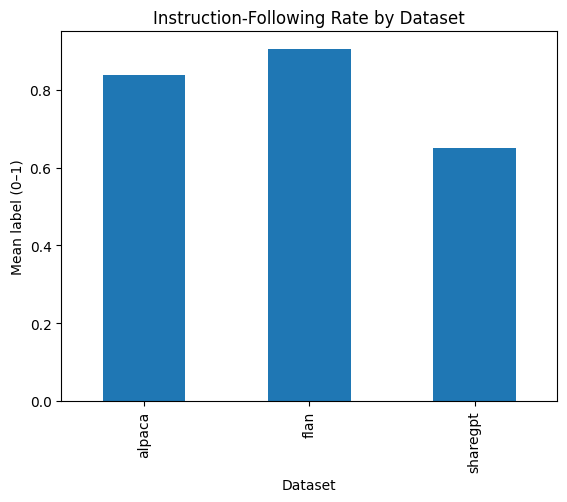

In [17]:
import matplotlib.pyplot as plt

# 1) Dataset-level compliance
dataset_rates = df_scored.groupby("dataset")["label"].mean()

plt.figure()
dataset_rates.plot(kind="bar")
plt.title("Instruction-Following Rate by Dataset")
plt.ylabel("Mean label (0–1)")
plt.xlabel("Dataset")
plt.show()


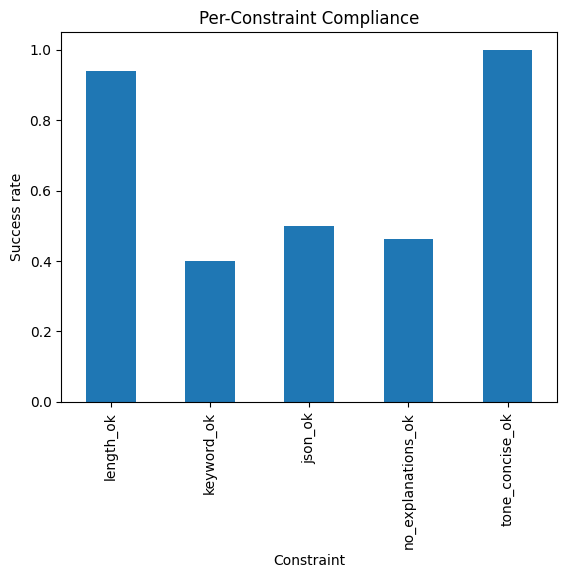

In [18]:
constraint_means = {}
for col in ["length_ok", "keyword_ok", "json_ok", "no_explanations_ok", "tone_concise_ok"]:
    if col in df_scored.columns:
        constraint_means[col] = mean_not_null(df_scored[col])

constraint_series = pd.Series(constraint_means)

plt.figure()
constraint_series.plot(kind="bar")
plt.title("Per-Constraint Compliance")
plt.ylabel("Success rate")
plt.xlabel("Constraint")
plt.show()


## Summary

- We imported `behavior_labels.csv` and inspected its structure.
- We computed the overall instruction-following rate across all scored examples.
- We broke down compliance by dataset (Alpaca, FLAN, ShareGPT).
- We estimated per-constraint compliance for:
  - length limits,
  - keyword requirements,
  - JSON formatting,
  - no-explanations constraints,
  - tone/conciseness.
- These empirical rates validate that our heuristic labeler is working end-to-end
  and provide a behavioral baseline that can later be correlated with
  attention metrics (PAM/QAM/SAM) and PCL measures.


In [19]:
df_json = df_scored[df_scored["constraint_tags"].str.contains("format_json", na=False)]
df_json[["id", "assistant_generated", "json_ok", "reasons"]]


,id,assistant_generated,json_ok,reasons
48,alpaca:10236,"{""answer"": ""ok"", ""value"": 1}",1.0,json_ok
73,sharegpt_en:6445,not valid json,0.0,json_invalid


##  Summary of Week 1 Work: Behavioral Heuristic Labeler

 successfully completed the main technical deliverable for **Researcher 3 (Behavior Analyst)** by designing, implementing, and validating the **Heuristic Scoring Engine**.

---

### 1. What I was able to Achieve (The Deliverable)

 created a fully functional Colab pipeline that established the project's **Behavioral Metric**. Specifically, I:

* **Implemented Heuristics:** Developed the core Python logic (`parse_length_limit`, `check_format_json`, etc.) to automatically and objectively check for compliance against our five locked constraints: `length_limit`, `keyword_X`, `format_json`, `no_explanations`, and `tone\_concise`.
* **Created the Scorer Function:** Designed the central function, `score_instruction_following`, which takes the prompt/answer texts and applies all relevant heuristics to produce a single, binary **instruction-following label ($\mathbf{y}$)** (1 for compliant, 0 for violation).
* **Validated the Pipeline:** Used a **synthetic answer generator** (`make_dummy_answer`) to intentionally test edge cases (e.g., generating invalid JSON, overly long answers). This was a critical step to prove the scoring logic works correctly *before* running expensive model inference.
* **Generated the Artifact:** Produced the main deliverable, **`behavior_labels.csv`**, which contains the final binary label and per-constraint pass/fail flags for each example.
* **Computed Baseline Statistics:** Calculated and visualized the preliminary compliance rates overall, by dataset, and by constraint type, confirming the output is ready for analysis.

---

### 2. Why This is Crucial (Project Impact)

The work established the **objective ground truth** for the model's behavior. This truth is the **outcome variable** that all other metrics will be tested against:

| Metric | Role in Project |
| :--- | :--- |
| **Binary Label ($\mathbf{y}$)** | The **Outcome Variable**. This is the measurable obedience score we will attempt to explain. |
| **Heuristic Engine** | The **Source of Truth**. It converts the qualitative goal of "obeying instructions" into a quantitative, reproducible metric, removing subjective human judgment. |

By delivering this reliable, quantitative behavioral measure, we have provided the necessary foundation for **Week 3's Metric Computation**, where we will correlate the attention metrics (**PAM/QAM/SAM**) with this compliance score ($\mathbf{y}$) to test our core hypotheses.